## Imports

In [1]:
import os
import json
import pysam
import gcsfs
import tarfile
import upsetplot

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

from google.cloud import storage
from collections import Counter
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import cm
from tabulate import tabulate
from IPython.core.display import display, HTML

/tmp/ipykernel_167/464170903.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# ! pip install upsetplot

## Constants

In [3]:
use_cache = True

include_vapor = True

distinct_vapor_no_call = False

# run = "benchmark"
run = "evaluation"

subset = "pb_vFinal"

min_size_cache = None
max_size_cache = None
valid_types_cache = ["DEL", "DUP", "INS", "INV", "BND", "CNV", "CPX"]

min_size_filter = None
max_size_filter = 5000
valid_types_filter = ["DEL", "DUP", "INS", "INV"]
    
info_fields = ["SVTYPE", "AF", "STRAT"]

format_fields = ["GT", "GQ", "SL"]

mode = "strict"

if run == "evaluation":
    sr_callers = ["depth", "dragen", "scramble", "wham"]
elif run == "benchmark":
    sr_callers = ["depth", "manta", "scramble", "wham"]
else:
    sr_callers = None

if "pb" in subset:
    lr_callers = ["PBSV", "SNIFFLES"]
    vcf_shards = {
        "PBSV": "shard-0",
        "SNIFFLES": "shard-1",
    }
    samples_filter = ["RGP_1446_1", "RGP_1446_3", "RGP_1883_3", "RGP_2166_1", "RGP_2166_3"]
elif "ont" in subset:
    lr_callers = ["SNIFFLES", "HAPDIFF"]
    vcf_shards = {
        "SNIFFLES": "shard-0",
        "HAPDIFF": "shard-1"
    }
    samples_filter = ["RGP_1219_1", "RGP_1608_3", "RGP_1219_2", "RGP_25_1"]

In [4]:
in_dir = f"/home/jupyter/Files/{run}/inputs/{subset}"
out_dir = f"/home/jupyter/Files/{run}/outputs/{subset}/{mode}"
os.makedirs(out_dir, exist_ok=True)

recalibrator_json = os.path.join(in_dir, "gq_recalibrator_labels.vapor.json")
input_file_path = os.path.join(in_dir, f"{mode}.txt")
sites_vcf_path = os.path.join(in_dir, "concat_training_sample_vcfs.vcf.gz")

tsv_files = {
    shard: os.path.join(out_dir, f"{caller}.tsv") 
    for caller, shard in vcf_shards.items()
}

cached_df_path = os.path.join(out_dir, "cached_df.tsv")

palette = sns.set_palette("muted")

fm.fontManager.addfont("/home/jupyter/Files/benchmark/inputs/Archive/arial.ttf")
fm.fontManager.addfont("/home/jupyter/Files/benchmark/inputs/Archive/arialbd.ttf")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

## Helper Functions

In [5]:
_gt_non_ref_map = dict()

def _is_non_ref(gt):
    s = _gt_non_ref_map.get(gt, None)
    if s is None:
        s = any([a is not None and a > 0 for a in gt])
        _gt_non_ref_map[gt] = s
    return s

In [6]:
def clean_directory(out_dir_):
    for root, dirs, files in os.walk(out_dir_):
        for name in files:
            file_path = os.path.join(root, name)
            if file_path not in tsv_files.values():
                os.remove(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            if not os.listdir(dir_path):
                os.rmdir(dir_path)

In [7]:
def compute_summary(df, filter_col, filter_val, n_samples, support_val=1, pre_filter=False, check_binary=False, filter_col2=None, filter_val2=None):
    df_filtered = df[df[filter_col] == filter_val] if pre_filter else df
    if filter_col2 is not None and filter_val2 is not None:
        df_filtered = df_filtered[df_filtered[filter_col2] == filter_val2]
    
    calls_count = df_filtered.shape[0]
    calls_supported_count = df_filtered[(df_filtered["N_LR_SUPPORT"] >= support_val) & (df_filtered[filter_col] == 1)].shape[0] if check_binary else df_filtered[df_filtered["N_LR_SUPPORT"] >= support_val].shape[0]
    
    calls_per_genome = round(calls_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_per_genome = round(calls_supported_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_proportion = f"{round((calls_supported_count / calls_count) * 100, 2)}%" if calls_count > 0 else 0
    
    filter_val = f"{filter_val} + {filter_val2}" if filter_col2 is not None and filter_val2 is not None else filter_val
    return [ filter_val, calls_per_genome, calls_supported_per_genome, calls_supported_proportion ]

In [8]:
def plot_hist(data, x, distinct_vapor_no_call=False, **kwargs):
    if distinct_vapor_no_call and "hue" in kwargs and kwargs["hue"] == "SUPPORT":
        data = data.copy()
        data["SUPPORT_DISTINCT"] = data["SUPPORT"].copy()
        if not pd.api.types.is_categorical_dtype(data["SUPPORT_DISTINCT"]):
            data["SUPPORT_DISTINCT"] = pd.Categorical(data["SUPPORT_DISTINCT"], categories=list(data["SUPPORT"].unique()) + ["Vapor No Call"])
        else:
            data["SUPPORT_DISTINCT"] = data["SUPPORT_DISTINCT"].cat.add_categories(["Vapor No Call"])
        data.loc[data["STATUS_VAPOR"] == -1, "SUPPORT_DISTINCT"] = "Vapor No Call"
        kwargs["hue"] = "SUPPORT_DISTINCT"
        
    g = sns.displot(
        data, x=x,
        multiple="stack",
        edgecolor=".3",
        linewidth=0.5,
        height=3, aspect=1.7,
        **kwargs
    )
    
    if str(data[x].dtype) == "object" or isinstance(data[x].dtype, pd.CategoricalDtype):
        rotation = 90
        for i, ax in enumerate(g.fig.axes):
            ticks_loc = ax.get_xticks()
            ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
            ax.set_xticklabels([x for x in ax.get_xticklabels()], rotation=rotation)
    plt.show()

In [9]:
def plot_averaged_hist(data, group_col, n_samples, support_col="SUPPORT", distinct_vapor_no_call=False, **kwargs):
    df_plot = data.copy()

    if pd.api.types.is_categorical_dtype(df_plot[group_col]):
        df_plot[group_col] = df_plot[group_col].cat.remove_unused_categories()
    plot_support_col = support_col

    if distinct_vapor_no_call and support_col == "SUPPORT":
        plot_support_col = "SUPPORT_DISTINCT"
        df_plot[plot_support_col] = df_plot["SUPPORT"].copy()
        if not pd.api.types.is_categorical_dtype(df_plot[plot_support_col]):
            df_plot[plot_support_col] = pd.Categorical(
                df_plot[plot_support_col],
                categories=list(df_plot["SUPPORT"].unique()) + ["Vapor No Call"]
            )
        else:
            df_plot[plot_support_col] = df_plot[plot_support_col].cat.add_categories(["Vapor No Call"])
        df_plot.loc[df_plot["STATUS_VAPOR"] == -1, plot_support_col] = "Vapor No Call"
    
    grouped = df_plot.groupby([group_col, plot_support_col]).size().unstack(fill_value=0)
    grouped = grouped / n_samples

    ax = grouped.plot(kind="bar", stacked=True, **kwargs)
    
    ax.set_xlabel(group_col)
    ax.set_ylabel("Calls per Genome")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        group_idx = int(x + width/2)
        total = grouped.iloc[group_idx].sum()
        if total > 0:
            percent = height / total * 100
            label = f"{percent:.2f}%"
            if height < 100:
                x_offset = 0.02
                y_offset = 50
                ax.text(x + width + x_offset, y + height/2 + y_offset, label, ha="left", va="center", color="black", fontsize=12)
            else:
                ax.text(x + width/2, y + height/2, label, ha="center", va="center", color="black", fontsize=12)
                
    totals = grouped.sum(axis=1)
    ylim = ax.get_ylim()
    offset = (ylim[1] - ylim[0]) * 0.01
    xticks = ax.get_xticks()
    for i, total in enumerate(totals):
        ax.text(xticks[i], total + offset, f"{total:.2f}", ha="center", va="bottom", fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [10]:
def plot_incremental_hist(data, include_vapor=False, distinct_vapor_no_call=False, **kwargs):
    data = data.copy()
    original_vals = sorted(data["N_LR_SUPPORT"].unique())
    unique_vals = original_vals if include_vapor and distinct_vapor_no_call else [v for v in original_vals if v > 0]
    
    if include_vapor:
        data.loc[data["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
    incremental_counts = {}
    
    for val in unique_vals:
        if include_vapor:
            if val == -1:
                subset = data[data["STATUS_VAPOR"] == -1]
            else:
                subset = data[(data["STATUS_VAPOR"] != -1) & (data["N_LR_SUPPORT"] >= val)]
        else:
            subset = data[data["N_LR_SUPPORT"] >= val]
        incremental_counts[val] = subset.shape[0] / len(data)
    inc_df = pd.DataFrame({"Threshold": list(incremental_counts.keys()), "Proportion": list(incremental_counts.values())})
    
    if include_vapor:
        inc_df["Threshold"] = inc_df["Threshold"].replace({-1: "Vapor No Call"})
    ax = sns.barplot(x="Threshold", y="Proportion", data=inc_df, **kwargs)
    plt.xlabel("Number of Supporting Callers")
    plt.ylabel("Proportion of Calls")
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f"{height*100:.2f}%", ha="center", va="bottom")
    plt.show()

In [11]:
def get_precision_recall_data(data, name, reverse=False, beta=1):
    results = dict()
    keys = data['SVTYPE'].unique().tolist()
    keys.insert(0, "ALL")

    for key in keys:
        if key == "ALL":
            df2 = data
        else:
            df2 = data[(data["SVTYPE"] == key)]

        y_scores = df2[name]
        not_nan = ~y_scores.isnull()
        y_scores = y_scores[not_nan]
        if len(y_scores) <= 1:
            continue

        results[key] = dict()
        results[key]["ppv"] = []
        results[key]["tpr"] = []
        results[key]["thresholds"] = []

        weights = df2["WEIGHT"][not_nan]
        if reverse:
            y_scores = -y_scores
        y_labels = df2.loc[not_nan, "LABEL"]
        ppv_i, tpr_i, thresholds_i = metrics.precision_recall_curve(
            y_labels, y_scores, sample_weight=weights, pos_label=1
        )
        if len(thresholds_i) <= 1:
            continue

        n = y_labels.shape[0]
        results[key]["ppv"] = ppv_i
        results[key]["tpr"] = tpr_i
        results[key]["thresh"] = thresholds_i
        results[key]["n"] = n
    return results

In [12]:
def plot_precision_recall(results, name, reverse=False):
    keys = [k for k in results.keys() if len(results[k]["tpr"]) > 0]
    fig = plt.figure(figsize=(16, 4))
    for k in keys:
        r = results[k]
        plt.subplot(1, 3, 1)
        plt.step(r["tpr"], r["ppv"])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend(keys)
        t = np.asarray(r["thresh"])
        if reverse:
            t = -t

        plt.subplot(1, 3, 2)
        plt.step(t, r["tpr"][:-1], where="pre")
        plt.xlabel(name)
        plt.ylabel("Recall")

        plt.subplot(1, 3, 3)
        plt.step(t, r["ppv"][:-1], where="pre")
        plt.xlabel(name)
        plt.ylabel("Precision")
    plt.show()

In [13]:
def plot_upset_lr(input_df, min_subset_size=None, by_svtype=True, ylim=None):
    upset_df = input_df.copy()
    if "VAPOR" in lr_callers and include_vapor:
        upset_df["vapor"] = upset_df["STATUS_VAPOR"]
    
    for c in lr_callers:
        if c != "VAPOR":
            upset_df[c.lower()] = upset_df["STATUS_" + c]
    
    active_callers = []
    for c in lr_callers:
        if c == "VAPOR" and include_vapor:
            active_callers.append("vapor")
        elif c != "VAPOR":
            active_callers.append(c.lower())
    
    upset_df = upset_df.set_index(upset_df[active_callers[0]] == 1)
    for sc in active_callers[1:]:
        upset_df = upset_df.set_index(upset_df[sc] == 1, append=True)
    if by_svtype:
        upset = upsetplot.UpSet(
            upset_df, subset_size="count", min_subset_size=min_subset_size, intersection_plot_elements=0
        )
        upset.add_stacked_bars(by="SVTYPE", colors=cm.Set2, title="Intersection Size", elements=10)
    else:
        upset = upsetplot.UpSet(upset_df, subset_size="count", min_subset_size=min_subset_size)
    
    upset.add_catplot(value="log_SVLEN", kind="violin", color="gray")
    if "SL" in input_df.columns:
        upset.add_catplot(value="SL", kind="box", color="gray", fliersize=0)
    
    fig = plt.figure(dpi=100)
    upset_axes = upset.plot(fig=fig)
    intersect_key = 'extra0' if by_svtype else 'intersections'
    if ylim is not None:
        upset_axes[intersect_key].set_ylim(ylim)
    plt.show()

In [14]:
def plot_upset_sr(input_df, min_subset_size=None, by_svtype=True, ylim=None):
    upset_df = input_df.copy()
    upset_df = upset_df.set_index(upset_df[sr_callers[0].upper()] == 1)
    for sc in sr_callers[1:]:
        upset_df = upset_df.set_index(upset_df[sc.upper()] == 1, append=True)

    if by_svtype:
        upset = upsetplot.UpSet(
            upset_df, subset_size="count", min_subset_size=min_subset_size, intersection_plot_elements=0
        )
        upset.add_stacked_bars(by="SVTYPE", colors=cm.Set2, title="Intersection Size", elements=10)
    else:
        upset = upsetplot.UpSet(upset_df, subset_size="count", min_subset_size=min_subset_size)

    upset.add_catplot(value="log_SVLEN", kind="violin", color="gray")
    if "N_LR_SUPPORT" in input_df.columns:
        upset.add_catplot(value="N_LR_SUPPORT", kind="violin", color="gray")

    fig = plt.figure(dpi=100)
    upset_axes = upset.plot(fig=fig)
    intersect_key = 'extra0' if by_svtype else 'intersections'
    if ylim is not None:
        upset_axes[intersect_key].set_ylim(ylim)
    plt.show()

## Process

### Verification

In [15]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [16]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [17]:
# Load per-caller VCFs

if not use_cache:
    gcs_client = storage.Client()
    
    for shard_path in tsv_files.values():
        os.makedirs(os.path.dirname(shard_path), exist_ok=True)
        with open(shard_path, "w") as f:
            f.write(
                "\t".join(
                    ["VID", "SAMPLE", "CHROM", "SVLEN", "STATUS"]
                    + [sc.upper() for sc in sr_callers]
                    + ["PE", "SR", "RD"]
                    + format_fields
                    + info_fields
                )
                + "\n"
            )

    if os.path.exists(input_file_path):
        with open(input_file_path, "r") as f:
            tarball_paths = [line.strip() for line in f.readlines()]
    else:
        tarball_paths = []

    shard_to_caller = {v: k for k, v in vcf_shards.items()}

    for tarball_path in tarball_paths:
        tarball_filename = os.path.basename(tarball_path)
        local_tarball_path = os.path.join(out_dir, tarball_filename)
        bucket_name, object_name = tarball_path[5:].split("/", 1)
        bucket = gcs_client.bucket(bucket_name)
        blob = bucket.blob(object_name)
        blob.download_to_filename(local_tarball_path)
        with tarfile.open(local_tarball_path, "r:gz") as tar:
            tar.extractall(out_dir)

        full_paths = []
        for root, dirs, files in os.walk(out_dir):
            if not dirs:
                for file in files:
                    if file.endswith(".vcf.gz"):
                        full_paths.append(os.path.join(root, file))

        candidate = False
        for path_ in full_paths:
            for kc in vcf_shards.keys():
                if kc.lower() in path_.lower():
                    candidate = True
                    break

        if not candidate:
            clean_directory(out_dir)
            continue

        for file_path in full_paths:
            shard = None
            for d_ in file_path.split(os.sep):
                if "shard" in d_.lower():
                    shard = d_
            
            caller = shard_to_caller.get(shard)
            if not caller:
                continue
            
            tsv_out = tsv_files[shard]
            with pysam.VariantFile(file_path) as vcf, open(tsv_out, "a") as tsv_handle:
                for r in vcf:
                    svtype = r.info.get("SVTYPE", None)
                    svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
                    
                    if valid_types_cache is not None:
                        if svtype not in valid_types_cache:
                            continue
                    
                    if max_size_cache is not None:
                        if svlen > max_size_cache:
                            continue
                            
                    if min_size_cache is not None:
                        if svlen < min_size_cache:
                            continue

                    row_data = []
                    for s in r.samples:
                        if _is_non_ref(r.samples[s]["GT"]):
                            algos = r.info.get("ALGORITHMS", [])
                            if isinstance(algos, str):
                                algos = [algos]
                                
                            sr_flags = []
                            for sc in sr_callers:
                                if sc in algos:
                                    sr_flags.append(1)
                                else:
                                    sr_flags.append(0)
                            
                            base = [
                                r.id,
                                s,
                                r.chrom,
                                svlen,
                                1 if r.info.get("STATUS", "") == "TP" else 0,
                            ] + sr_flags + [
                                1 if "PE" in r.samples[s].get("EV", []) else 0,
                                1 if "SR" in r.samples[s].get("EV", []) else 0,
                                1 if "RD" in r.samples[s].get("EV", []) else 0,
                            ]
                            
                            fmts = [r.samples[s].get(k, None) for k in format_fields]
                            
                            infs = [r.info.get(k, None) for k in info_fields]
                            
                            row_data.append(base + fmts + infs)
                    
                    if row_data:
                        for rd_ in row_data:
                            tsv_handle.write("\t".join(str(x) for x in rd_) + "\n")

        clean_directory(out_dir)

In [18]:
# Save sites to disk

if not use_cache:
    info_fields.remove("STRAT")
        
    with pysam.VariantFile(sites_vcf_path) as vcf, open(os.path.join(out_dir, "sites.tsv"), "w") as fout:
        fout.write("\t".join(["VID", "CHROM", "SVLEN", "FILTER"] + info_fields) + "\n")
        for r in vcf:
            svtype = r.info.get("SVTYPE", None)
            svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)
            filters = ",".join(f for f in r.filter)
            
            if valid_types_cache is not None:
                if svtype not in valid_types_cache:
                    continue
            
            if max_size_cache is not None:
                if svlen > max_size_cache:
                    continue
                    
            if min_size_cache is not None:
                if svlen < min_size_cache:
                    continue
            
            r_data = [r.id, r.chrom, svlen, filters] + [r.info.get(k, None) for k in info_fields]
            fout.write("\t".join(str(x) for x in r_data) + "\n")

### Dataframe Generation

In [19]:
# Load Vapor labels into memory

if not use_cache:
    if include_vapor:
        with open(recalibrator_json, "r") as f:
            tmp = json.load(f)
        vapor_labels = {}
        for s in tmp:
            vapor_labels[s] = {
                "good_variant_ids": set(tmp[s]["good_variant_ids"]),
                "bad_variant_ids": set(tmp[s]["bad_variant_ids"])
            }
    else:
        vapor_labels = {}

In [20]:
# Join files

if not use_cache:
    # Load df_sites
    df_sites = pd.read_csv(os.path.join(out_dir, "sites.tsv"), sep="\t")

    # Load df_ref for a single reference caller
    ref_caller = lr_callers[0]
    ref_shard = vcf_shards[ref_caller]
    ref_tsv_path = tsv_files[ref_shard]
    df_ref = pd.read_csv(ref_tsv_path, sep="\t")

    # Only include new columns from df_ref
    overlap_cols = set(df_ref.columns).intersection(df_sites.columns) - {"VID", "SAMPLE"}
    df_ref.drop(columns=list(overlap_cols), inplace=True, errors="ignore")

    # Merge df_sites with df_ref
    df = df_sites.set_index("VID").join(df_ref.set_index("VID"), how="right").reset_index()

    # Create ID
    df["ID"] = df["VID"].astype(str) + "_" + df["SAMPLE"].astype(str)

    # Bring in STATUS column from other callers
    for caller in lr_callers[1:]:
        shard = vcf_shards[caller]
        tsv_path = tsv_files[shard]
        df_other = pd.read_csv(tsv_path, sep="\t")

        # Build matching ID = VID + "_" + SAMPLE
        df_other["ID"] = df_other["VID"].astype(str) + "_" + df_other["SAMPLE"].astype(str)

        # Rename STATUS -> STATUS_{caller}, keep only that col + ID
        df_other.rename(columns={"STATUS": f"STATUS_{caller}"}, inplace=True)
        df_other = df_other[["ID", f"STATUS_{caller}"]]

        # Join on ID
        df = (
            df.set_index("ID")
            .join(
                df_other.set_index("ID"),
                how="left"
            )
            .reset_index()
        )
        
    # Set final index
    df = df.set_index("ID")
    
    # Rename STATUS column
    df = df.rename(columns={"STATUS": f"STATUS_{ref_caller}"})

### Dataframe Processing

In [21]:
# Formatting 

if not use_cache:
    # Set STATUS_VAPOR
    if include_vapor:
        df["STATUS_VAPOR"] = df.apply(
            lambda row: (
                1 if row["SAMPLE"] in vapor_labels and row["VID"] in vapor_labels[row["SAMPLE"]]["good_variant_ids"]
                else (0 if row["SAMPLE"] in vapor_labels and row["VID"] in vapor_labels[row["SAMPLE"]]["bad_variant_ids"]
                      else -1)
            ), axis=1
        )
        lr_callers.append("VAPOR")

    # Set AF
    if "AF" in df.columns:
        df["AF"] = df["AF"].astype(str).str.replace(r"[(),]", "", regex=True).astype(float)

    # Set column types
    df = df.dropna(subset=["SVLEN"]).astype({"SVLEN": int, "SVTYPE": str})
    if "GQ" in df.columns:
        df["GQ"] = df["GQ"].astype(float)
    if "SL" in df.columns:
        df["SL"] = df["SL"].astype(float)
        
    # Process categorical
    df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

    # Process STRAT
    if "STRAT" in df.columns:
        def assign_strat(s):
            if pd.isna(s):
                return "Unique"
            elif "SR_" in s:
                return "SR"
            elif "SD_" in s:
                return "SD"
            elif "RM_" in s:
                return "RM"
            else:
                return "Unique"

        df["STRAT"] = df["STRAT"].apply(assign_strat)
        
        df['STRAT'] = pd.Categorical(df['STRAT'])

In [22]:
# Enhancement

if not use_cache:
    # Set log_SVLEN
    df["log_SVLEN"] = np.log10(df["SVLEN"].where(df["SVLEN"] > 0, np.nan))
    
    # Set SVCLASS
    df["SVCLASS"] = df["SVTYPE"].copy()
    df.loc[df["SVTYPE"] == "DUP", "SVCLASS"] = "INS"

    # Set SIZE
    df["SIZE"] = df["SVLEN"]
    df.loc[df["SVTYPE"] == "DEL", "SIZE"] = -df.loc[df["SVTYPE"] == "DEL", "SIZE"]

    # Set LRWGS
    df["LRWGS"] = 0
    for c in lr_callers:
        if c == "VAPOR" and not include_vapor:
            continue
        df.loc[df[f"STATUS_{c}"] == 1, "LRWGS"] = 1

    # Set SRWGS
    def sr_any(row):
        return any(row[sc.upper()] == 1 for sc in sr_callers)
    df["SRWGS"] = df.apply(sr_any, axis=1).astype(int)

    # Set SUPPORT
    df["SUPPORT"] = "SR"
    df.loc[(df["SRWGS"] == 1) & (df["LRWGS"] == 1), "SUPPORT"] = "SR+LR"
    df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

    # Set N_LR_SUPPORT
    df["N_LR_SUPPORT"] = 0
    for c in lr_callers:
        df["N_LR_SUPPORT"] += df[f"STATUS_{c}"]

In [23]:
if not use_cache:
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [24]:
df = pd.read_csv(cached_df_path, sep="\t")

if include_vapor and "VAPOR" not in lr_callers:
    lr_callers.append("VAPOR")

df.head()

,VID,CHROM,SVLEN,FILTER,SVTYPE,AF,SAMPLE,STATUS_PBSV,DEPTH,DRAGEN,...,STRAT,STATUS_SNIFFLES,STATUS_VAPOR,log_SVLEN,SVCLASS,SIZE,LRWGS,SRWGS,SUPPORT,N_LR_SUPPORT
0,all_sample_sets.chr1.final_cleanup_DEL_chr1_10,chr1,15113,PASS,DEL,0.004255,RGP_1059_1,1,1,1,...,SD,1,1,4.179351,DEL,-15113,1,1,SR+LR,3
1,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_101_2,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,SR+LR,3
2,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_101_3,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,SR+LR,3
3,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_1170_3,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,SR+LR,3
4,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_1253_3,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,SR+LR,3


In [25]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

df['STRAT'] = pd.Categorical(df['STRAT'])

df["SUPPORT"] = df["SUPPORT"].replace({"SR": "Unsupported", "SR+LR": "Supported"})
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

In [26]:
# Filtering

# Undo Vapor negation
# if include_vapor:
#     df.loc[df["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
# else:
#     if "STATUS_VAPOR" in df.columns:
#         df["N_LR_SUPPORT"] = df["N_LR_SUPPORT"] - df["STATUS_VAPOR"]

# Set Vapor no calls to false positives
if include_vapor:
    df.loc[df["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
    df.loc[df["STATUS_VAPOR"] == -1, "STATUS_VAPOR"] = 0
else:
    if "STATUS_VAPOR" in df.columns:
        df["N_LR_SUPPORT"] = df["N_LR_SUPPORT"] - df["STATUS_VAPOR"]

# Remove Vapor no calls
# if include_vapor:
#     bef = len(df)
#     df.loc[df["STATUS_VAPOR"] == -1, "N_LR_SUPPORT"] += 1
#     df = df[df["STATUS_VAPOR"] != -1]
#     print(f"[Vapor No Calls] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
# else:
#     if "STATUS_VAPOR" in df.columns:
#         df["N_LR_SUPPORT"] = df["N_LR_SUPPORT"] - df["STATUS_VAPOR"]
    
# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
if valid_types_filter is not None:
    bef = len(df)
    df = df[df["SVTYPE"].isin(valid_types_filter)]
    print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Remove invalid SAMPLE
if samples_filter is not None:
    bef = len(df)
    df = df[~df["SAMPLE"].isin(samples_filter)]
    print(f"[Invalid SAMPLE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Remove non-PASS FILTER
bef = len(df)
df = df[df["FILTER"].isna() | (df["FILTER"] == "PASS")]
print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Remove non-Caller variants
# caller = "DRAGEN" if run == "evaluation" else "MANTA"
# bef = len(df)
# df = df[df[caller] == 1]
# print(f"[{caller} only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

df.head()

[SVLEN > Max Size] Dropped 79679 records (4.82%), now left with 1572827.

[Invalid SVTYPE] Dropped 0 records (0.0%), now left with 1572827.

[Invalid SAMPLE] Dropped 0 records (0.0%), now left with 1572827.

[PASS Only] Dropped 68202 records (4.34%), now left with 1504625.



,VID,CHROM,SVLEN,FILTER,SVTYPE,AF,SAMPLE,STATUS_PBSV,DEPTH,DRAGEN,...,STRAT,STATUS_SNIFFLES,STATUS_VAPOR,log_SVLEN,SVCLASS,SIZE,LRWGS,SRWGS,SUPPORT,N_LR_SUPPORT
1,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_101_2,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,Supported,3
2,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_101_3,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,Supported,3
3,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_1170_3,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,Supported,3
4,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_1253_3,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,Supported,3
5,all_sample_sets.chr1.final_cleanup_DEL_chr1_1003,chr1,112,PASS,DEL,0.161702,RGP_1337_1,1,0,1,...,RM,1,1,2.049218,DEL,-112,1,1,Supported,3


## Analyze

### Statistics

In [27]:
display(HTML("<style>.container { width:100% !important; }</style>"))

total_calls = df.shape[0]
print(f"Total Calls: {total_calls}")

total_sites = df['VID'].nunique()
print(f"Total Unique Sites: {total_sites}")

n_samples = df['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

table_headers = [ "Calls/Genome", "Calls Supported/Genome", "% Calls Supported" ]

# N_LR_SUPPORT
table_rows = []
for i in range(df['N_LR_SUPPORT'].min(), df['N_LR_SUPPORT'].max() + 1):
    table_rows.append(compute_summary(df, "SRWGS", i, n_samples, support_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# STRAT
if "STRAT" in df.columns:    
    table_rows = []
    for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
        table_rows.append(compute_summary(df, "STRAT", strat, n_samples, pre_filter=True))
    print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# LR Caller
table_rows = []
for caller in lr_callers:
    table_rows.append(compute_summary(df, f"STATUS_{caller}", caller, n_samples, check_binary=True))
print(tabulate(table_rows, headers=["Caller"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVTYPE
table_rows = []
for svtype in df["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df, "SVTYPE", svtype, n_samples, pre_filter=True))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# SVLEN
svlen_bins = {
    "SVLEN < 500": df[df["SVLEN"] < 500],
    "SVLEN 500-1000": df[(df["SVLEN"] >= 500) & (df["SVLEN"] <= 1000)],
    "SVLEN > 1000": df[df["SVLEN"] > 1000]
}
table_rows = []
for label, subset in svlen_bins.items():
    table_rows.append(compute_summary(subset, "N_LR_SUPPORT", label, n_samples))
print(tabulate(table_rows, headers=["SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

non_vapor = [c for c in lr_callers if c != "VAPOR"]
sums_nv = df[[f"STATUS_{x}" for x in non_vapor]].sum(axis=1)
sup_nv = (sums_nv >= 1).sum()
prop_nv = sup_nv / total_calls * 100

print(f"Calls with support from non-Vapor long-read callers: {sup_nv}")
print(f"Proportion of calls with support from non-Vapor long-read callers: {prop_nv:.2f}%")

Total Calls: 1504625
Total Unique Sites: 36383
Total Unique Samples: 178

╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │    8452.95     │         8452.95          │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │    8452.95     │         7371.32          │        87.2%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   2    │    8452.95     │         7056.17          │       83.48%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   3    │    8452.95     │          6084.8          │       71.98%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

╒═════════╤════════════════╤══════════════════════════╤═════════════════════╕


In [28]:
# table_rows = []
# for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
#     for svtype in df["SVTYPE"].dropna().unique():
#         table_rows.append(compute_summary(df, "SVTYPE", svtype, n_samples, pre_filter=True, filter_col2="STRAT", filter_val2=strat))
# print(tabulate(table_rows, headers=["STRAT + SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4) + "\n")

# table_rows = []
# for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
#     for label, subset in svlen_bins.items():
#         table_rows.append(compute_summary(subset, "N_LR_SUPPORT", label, n_samples, filter_col2="STRAT", filter_val2=strat))
# print(tabulate(table_rows, headers=["STRAT + SVLEN"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

### Distributions

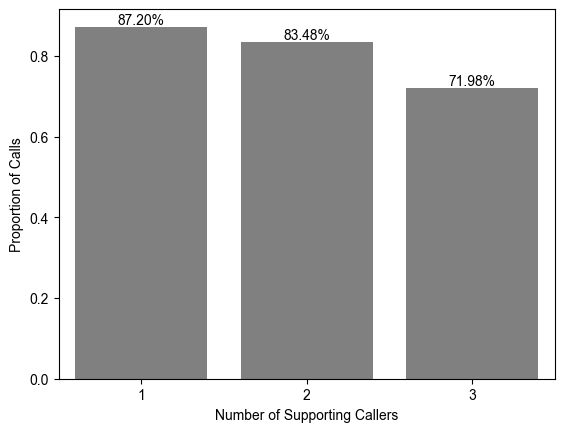

In [29]:
plot_incremental_hist(df, include_vapor=include_vapor, distinct_vapor_no_call=distinct_vapor_no_call, color="gray")

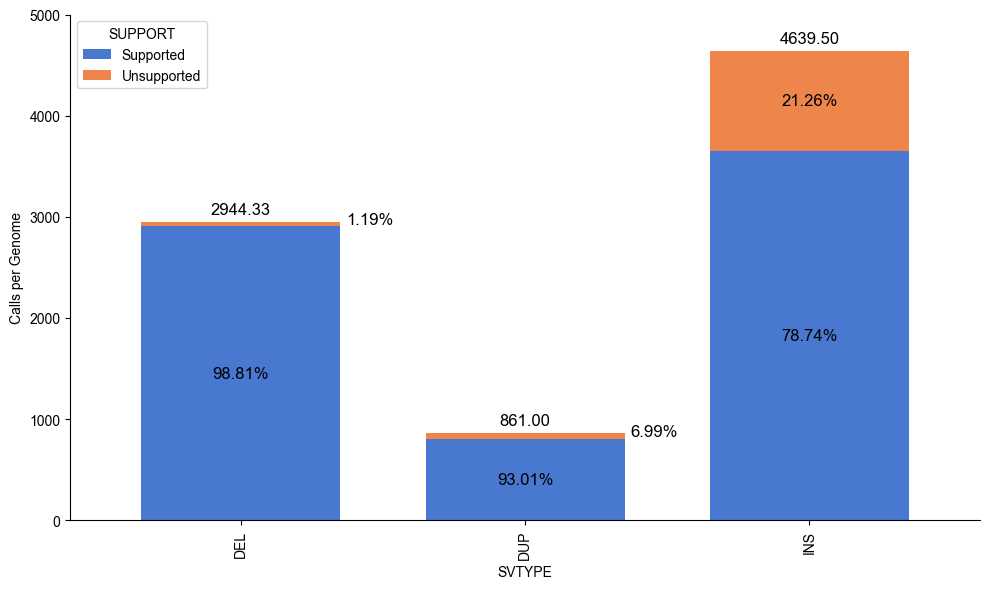

In [30]:
plot_averaged_hist(df[df['SVTYPE'] != 'INV'], group_col="SVTYPE", n_samples=n_samples, support_col="SUPPORT", distinct_vapor_no_call=distinct_vapor_no_call, ylim=(0, 5000), figsize=(10, 6), width=0.7)

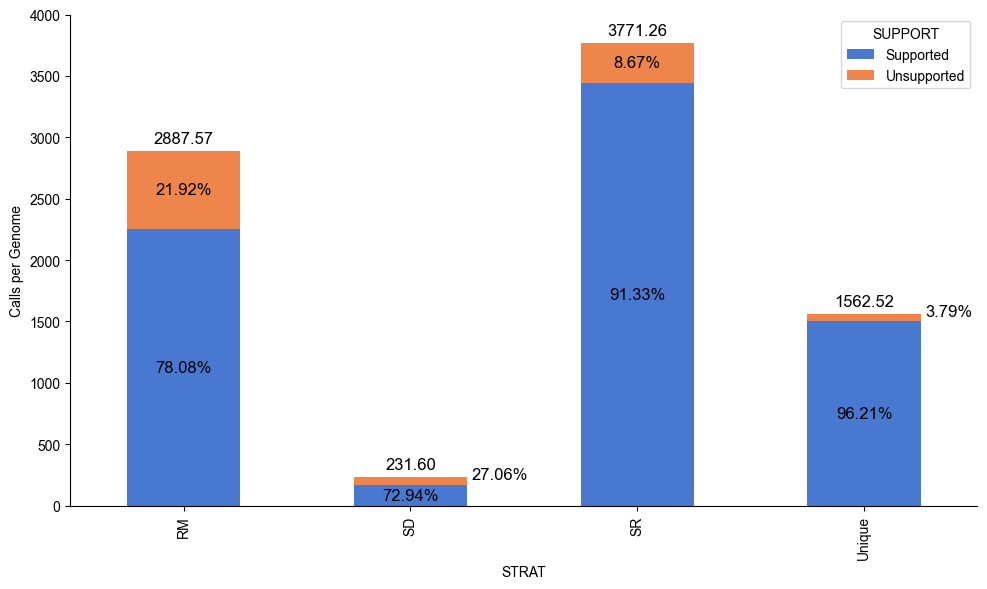

In [31]:
plot_averaged_hist(df, group_col="STRAT", n_samples=n_samples, support_col="SUPPORT", distinct_vapor_no_call=distinct_vapor_no_call, ylim=(0, 4000), figsize=(10, 6), width=0.5)

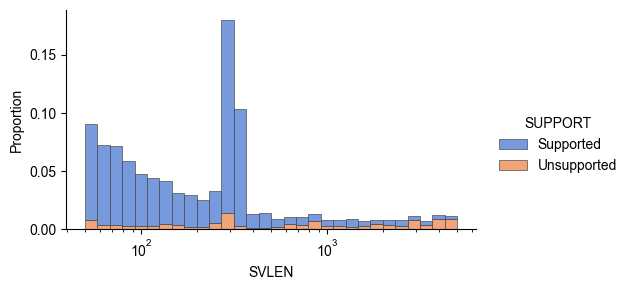

In [32]:
plot_hist(df, "SVLEN", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", log_scale=(True, False), bins=30)

In [33]:
# plot_hist(df, "SIZE", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", bins=30)

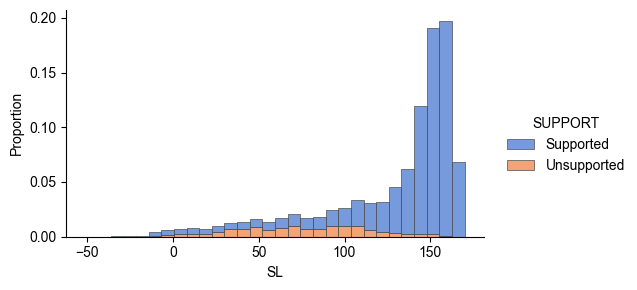

In [34]:
plot_hist(df, "SL", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", bins=30)

In [35]:
# plot_hist(df, "GQ", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion", bins=30)

In [36]:
# plot_hist(df[df['SVTYPE'] != 'INV'], "SVTYPE", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion")

In [37]:
# plot_hist(df, "STRAT", distinct_vapor_no_call=distinct_vapor_no_call, hue="SUPPORT", stat="proportion")

### Precision/Recall

N_LR_SUPPORT >= 1


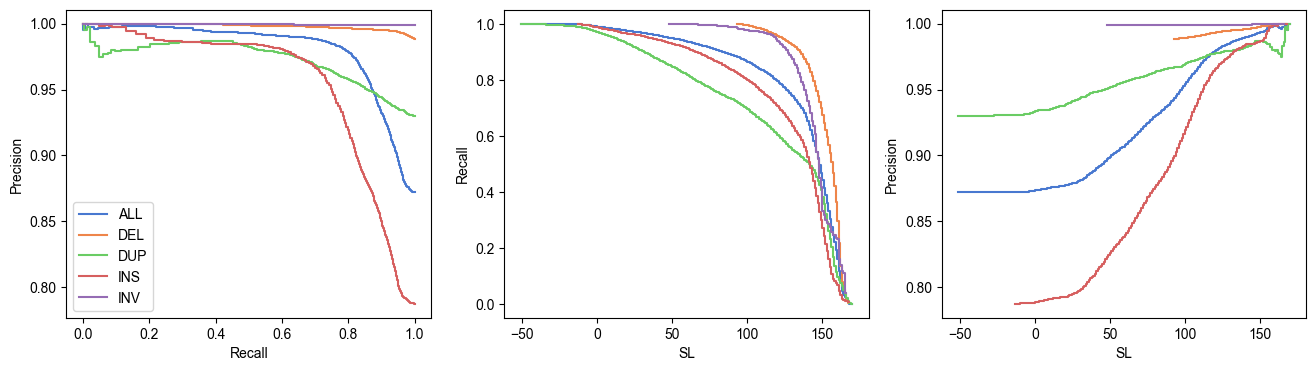

N_LR_SUPPORT >= 2


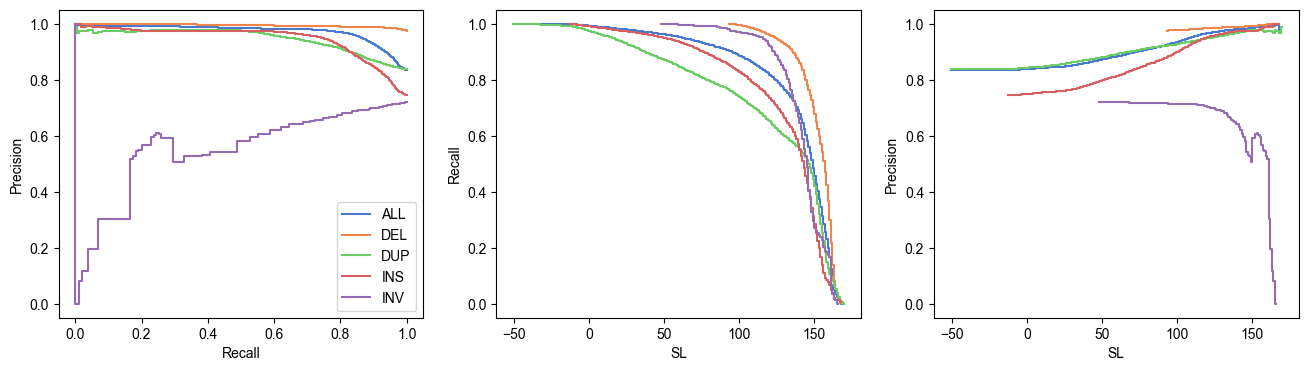

N_LR_SUPPORT >= 3


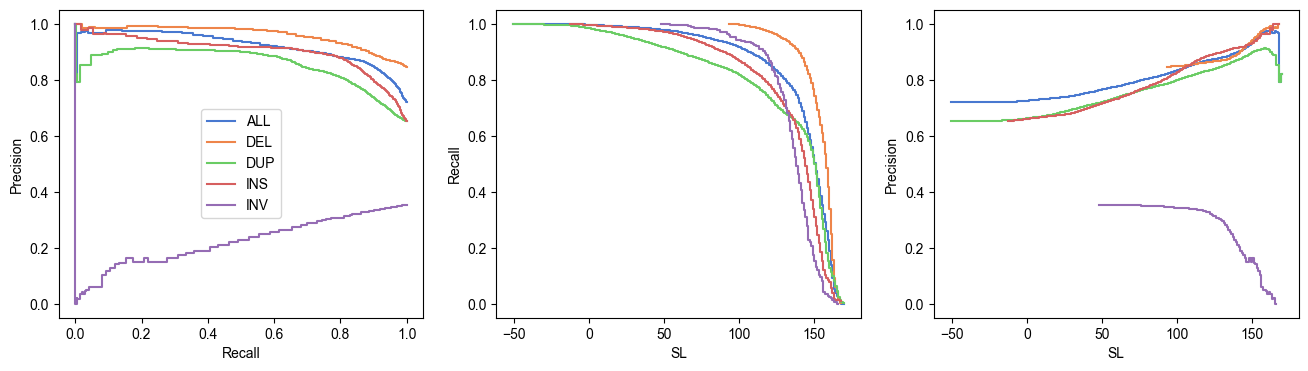

In [38]:
df["WEIGHT"] = 1

for i in range(1, 4):
    print(f"N_LR_SUPPORT >= {i}")
    df["LABEL"] = 0
    df.loc[df["N_LR_SUPPORT"] >= i, "LABEL"] = 1
    stats = get_precision_recall_data(df, "SL")
    plot_precision_recall(stats, "SL")

### Upset Plots

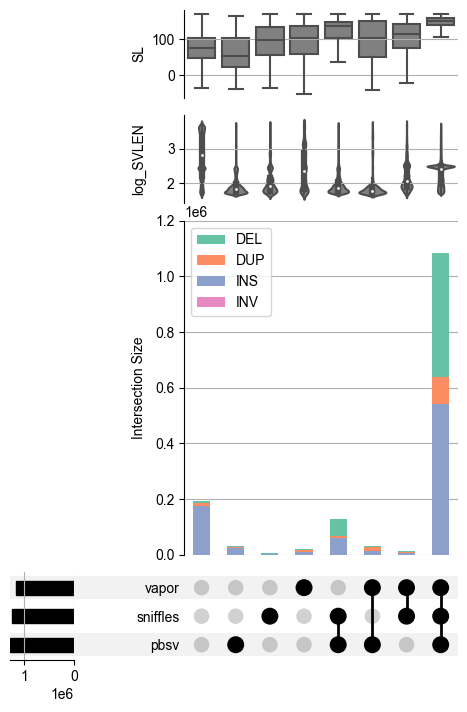

In [39]:
plot_upset_lr(df, ylim=(0, 1200000))

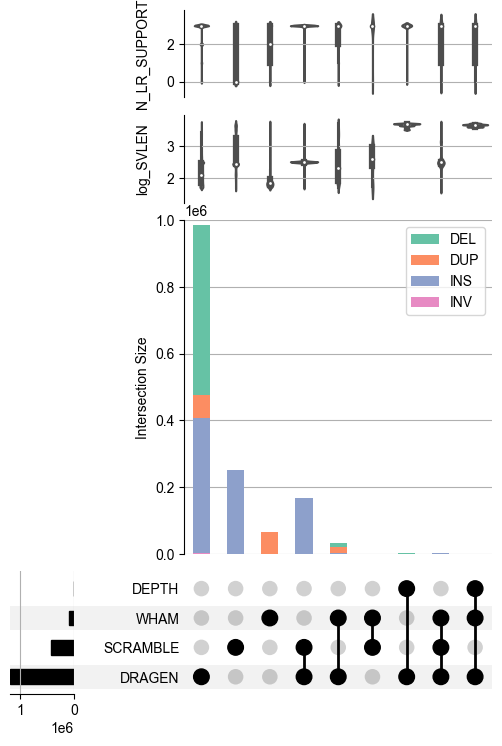

In [40]:
plot_upset_sr(df, ylim=(0, 1000000))

### Inversions

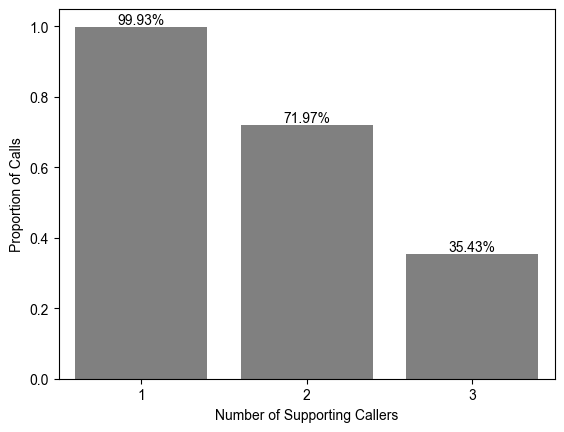

In [41]:
plot_incremental_hist(df[df["SVTYPE"] == "INV"], include_vapor=include_vapor, distinct_vapor_no_call=distinct_vapor_no_call, color="gray")

### Caller Concordance - SVLEN

In [42]:
def compare_callers_svlen(
    df, caller1, caller2,
    svtype=None, svtype_col="SVTYPE", svlen_col="SVLEN",
    sr_callers=[],
    save_path=None,
    xlabel_fontsize=None,
    ylabel_fontsize=None,
    tick_label_fontsize=None,
    legend_title_fontsize=None,
    legend_title=None,
    legend_labels=None,
    legend_order=None,
    legend_text_fontsize=None,
    **kwargs
):
    df_subset = df[df[svtype_col] == svtype].copy()
    common = (df_subset[caller1] == 1) & (df_subset[caller2] == 1)
    exclusive1 = (df_subset[caller1] == 1) & (df_subset[caller2] == 0)
    exclusive2 = (df_subset[caller2] == 1) & (df_subset[caller1] == 0)
    df_subset["concordance"] = np.where(
        common, "Intersection",
        np.where(exclusive1, f"Exclusive_{caller1}", np.where(exclusive2, f"Exclusive_{caller2}", "Other"))
    )
    
    plt.figure(**kwargs)
    ax = sns.histplot(
        data=df_subset[df_subset['concordance'] != 'Other'],
        x=svlen_col,
        hue="concordance",
        hue_order=legend_order,
        multiple="stack",
        log_scale=True,
        bins=50
    )
    
    plt.xlabel("Log(SV Length)", fontsize=xlabel_fontsize, fontweight='bold')
    plt.ylabel("Calls", fontsize=ylabel_fontsize, fontweight='bold')
    if tick_label_fontsize is not None:
        plt.tick_params(axis='both', which='major', labelsize=tick_label_fontsize)

    legend = ax.get_legend()
    if legend:
        if legend_title is not None:
            legend.set_title(legend_title, prop={'size': legend_title_fontsize})
        elif legend_title_fontsize is not None:
            plt.setp(legend.get_title(), fontsize=legend_title_fontsize)

        if legend_labels and isinstance(legend_labels, dict):
            for text in legend.get_texts():
                original_text = text.get_text()
                new_text = legend_labels.get(original_text, original_text)
                text.set_text(new_text)
        if legend_text_fontsize is not None:
            plt.setp(legend.get_texts(), fontsize=legend_text_fontsize)

    sns.despine()
    plt.tight_layout()

    if save_path:
        if legend:
            legend.get_frame().set_alpha(0)
        plt.savefig(
            save_path,
            transparent=True,
            dpi=300,
            bbox_inches='tight'
        )

    plt.show()

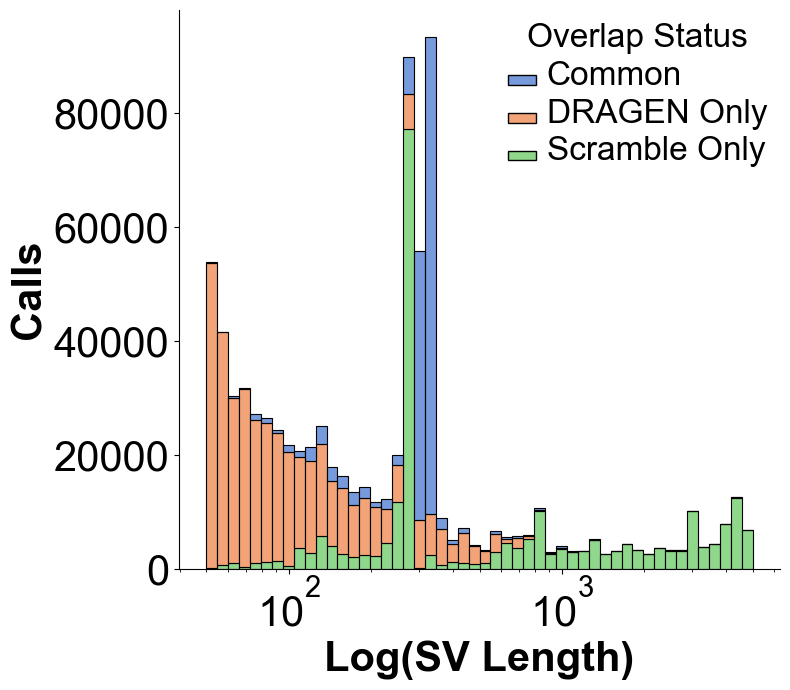

In [49]:
if run == "evaluation":
    compare_callers_svlen(df, "DRAGEN", "SCRAMBLE", svtype="INS", sr_callers=sr_callers, 
                          save_path=os.path.join(out_dir, "scramble_overlap.png"),
                          xlabel_fontsize=30, ylabel_fontsize=30, tick_label_fontsize=30,
                          legend_title_fontsize=24, legend_text_fontsize=24,
                          legend_title="Overlap Status", legend_order=["Intersection", "Exclusive_DRAGEN", "Exclusive_SCRAMBLE"],
                          legend_labels={
                              "Intersection": "Common",
                              "Exclusive_DRAGEN": "DRAGEN Only",
                              "Exclusive_SCRAMBLE": "Scramble Only"
                          }, figsize=(8, 7))
else:
    compare_callers_svlen(df, "MANTA", "SCRAMBLE", svtype="INS", sr_callers=sr_callers, figsize=(8, 7))

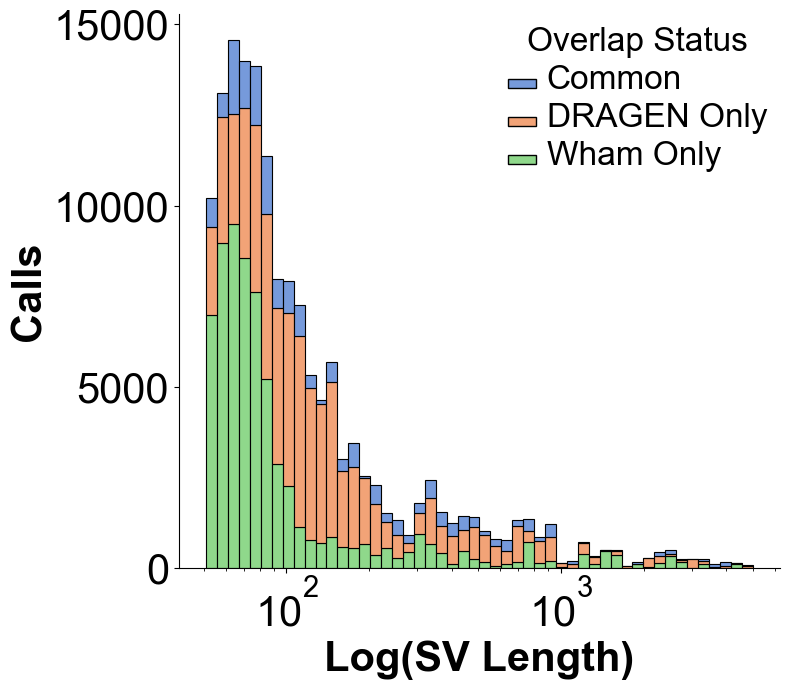

In [50]:
if run == "evaluation":
    compare_callers_svlen(df, "DRAGEN", "WHAM", svtype="DUP", sr_callers=sr_callers, 
                          save_path=os.path.join(out_dir, "wham_overlap.png"),
                          xlabel_fontsize=30, ylabel_fontsize=30, tick_label_fontsize=30,
                          legend_title_fontsize=24, legend_text_fontsize=24,
                          legend_title="Overlap Status", legend_order=["Intersection", "Exclusive_DRAGEN", "Exclusive_WHAM"],
                          legend_labels={
                              "Intersection": "Common",
                              "Exclusive_DRAGEN": "DRAGEN Only",
                              "Exclusive_WHAM": "Wham Only"
                          }, figsize=(8, 7))
else:
    compare_callers_svlen(df, "MANTA", "WHAM", svtype="DUP", sr_callers=sr_callers, figsize=(8, 7))

### Caller Concordance - SVTYPE

In [45]:
def compare_callers_svtype(df, caller1, caller2, svtype_col="SVTYPE", sr_callers=[]):
    df_subset = df.copy()
    desired_categories = ["Common", f"Exclusive_{caller1}", f"Exclusive_{caller2}"]    
    common = (df_subset[caller1] == 1) & (df_subset[caller2] == 1)
    exclusive1 = (df_subset[caller1] == 1) & (df_subset[caller2] == 0)
    exclusive2 = (df_subset[caller2] == 1) & (df_subset[caller1] == 0)
    
    df_subset["concordance"] = np.where(common, "Common", np.where(exclusive1, f"Exclusive_{caller1}", np.where(exclusive2, f"Exclusive_{caller2}", "Other")))
    counts = df_subset.groupby([svtype_col, "concordance"]).size().unstack(fill_value=0)
    counts = counts.reindex(columns=desired_categories, fill_value=0)
    supported = df_subset[df_subset["N_LR_SUPPORT"] >= 1].groupby([svtype_col, "concordance"]).size().unstack(fill_value=0)
    supported = supported.reindex(columns=desired_categories, fill_value=0)
    
    table_rows = []
    for group_label in counts.index:
        row = [str(group_label)]
        group_total = counts.loc[group_label].sum()
        for cat in desired_categories:
            count_val = counts.loc[group_label, cat]
            perc = (count_val / group_total * 100) if group_total > 0 else 0
            supp_count = supported.loc[group_label, cat]
            supp_perc = (supp_count / count_val * 100) if count_val > 0 else 0
            row.extend([f"{perc:.2f}%", f"{supp_perc:.2f}%"])
        table_rows.append(row)
    
    total_counts = counts.sum()
    total_all = total_counts.sum()
    total_supported = supported.sum()
    total_row = ["Total"]
    for cat in desired_categories:
        tot = total_counts[cat]
        perc = (tot / total_all * 100) if total_all > 0 else 0
        supp_count = total_supported[cat]
        supp_perc = (supp_count / tot * 100) if tot > 0 else 0
        total_row.extend([f"{perc:.2f}%", f"{supp_perc:.2f}%"])
    table_rows.append(total_row)
    
    headers = [svtype_col]
    for cat in desired_categories:
        headers.extend([f"{cat} %", f"{cat} % Supported"])
    print(tabulate(table_rows, headers=headers, tablefmt="fancy_grid", colalign=("center",)*len(headers)))
    
    stacked_counts = counts
    ax = stacked_counts.plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.xlabel(svtype_col)
    plt.ylabel("Count of Sites")
    plt.legend(title="Concordance", loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

╒══════════╤════════════╤══════════════════════╤══════════════════════╤════════════════════════════════╤════════════════════════╤══════════════════════════════════╕
│  SVTYPE  │  Common %  │  Common % Supported  │  Exclusive_DRAGEN %  │  Exclusive_DRAGEN % Supported  │  Exclusive_SCRAMBLE %  │  Exclusive_SCRAMBLE % Supported  │
╞══════════╪════════════╪══════════════════════╪══════════════════════╪════════════════════════════════╪════════════════════════╪══════════════════════════════════╡
│   DEL    │   0.00%    │        0.00%         │       100.00%        │             98.81%             │         0.00%          │              0.00%               │
├──────────┼────────────┼──────────────────────┼──────────────────────┼────────────────────────────────┼────────────────────────┼──────────────────────────────────┤
│   DUP    │   1.00%    │        97.49%        │        98.91%        │             95.39%             │         0.09%          │             100.00%              │
├─────────

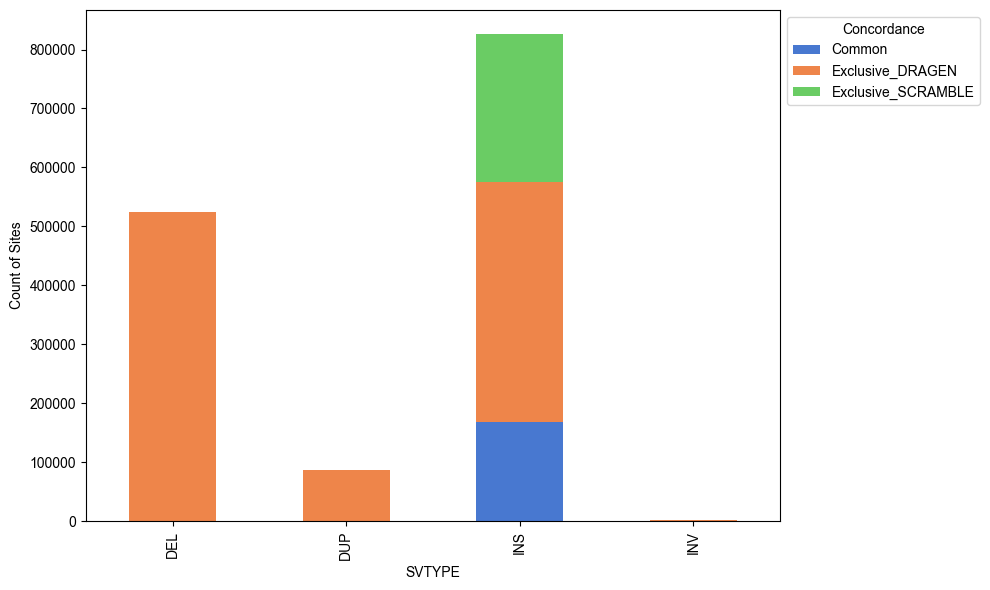

In [46]:
if run == "evaluation":
    compare_callers_svtype(df, "DRAGEN", "SCRAMBLE", sr_callers=sr_callers)
else:
    compare_callers_svtype(df, "MANTA", "SCRAMBLE", sr_callers=sr_callers)

╒══════════╤════════════╤══════════════════════╤══════════════════════╤════════════════════════════════╤════════════════════╤══════════════════════════════╕
│  SVTYPE  │  Common %  │  Common % Supported  │  Exclusive_DRAGEN %  │  Exclusive_DRAGEN % Supported  │  Exclusive_WHAM %  │  Exclusive_WHAM % Supported  │
╞══════════╪════════════╪══════════════════════╪══════════════════════╪════════════════════════════════╪════════════════════╪══════════════════════════════╡
│   DEL    │   2.59%    │        97.96%        │        97.41%        │             98.83%             │       0.00%        │            0.00%             │
├──────────┼────────────┼──────────────────────┼──────────────────────┼────────────────────────────────┼────────────────────┼──────────────────────────────┤
│   DUP    │   12.06%   │        93.28%        │        44.99%        │             95.98%             │       42.95%       │            89.82%            │
├──────────┼────────────┼──────────────────────┼──────────

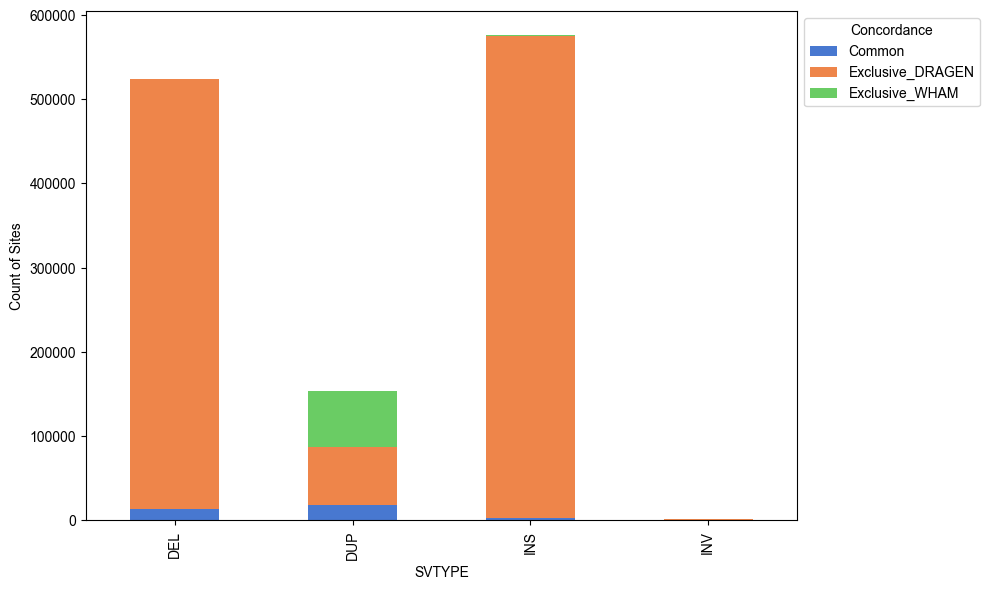

In [47]:
if run == "evaluation":
    compare_callers_svtype(df, "DRAGEN", "WHAM", sr_callers=sr_callers)
else:
    compare_callers_svtype(df, "MANTA", "WHAM", sr_callers=sr_callers)